# Import

In [1]:
from parcels import (
        FieldSet,
        JITParticle,
        ScipyParticle,
        ParticleSet,
        AdvectionRK4,
        AdvectionRK4_3D,
        StatusCode,
)
import parcels

import datetime as dt
from datetime import datetime, timedelta

import dask

import numpy as np
from numpy.random import uniform, randint

from pathlib import Path
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cmocean

import xarray as xr
from glob import glob
import cartopy
import cartopy.crs as ccrs
from time import time
import warnings
import shapely
import itertools



warnings.simplefilter("ignore")

# Set Parameters

In [2]:
# Parameters
RNG_seed = 123

# Time
release_year = 2016
first_release_month = 1
first_release_day = 1
last_release_month = 12
last_release_day = 31
max_age_d = 220
# timedirection
timearrow = 1
# Timestep in minutes
dt_in_minutes = 15
output_dt_in_minutes = 15

# Box traits
release_depth_sigma = 0

n_particles_per_cell = 10

repeated_release = True
repeatdt_d = 7

is_papermill = False


In [3]:
if not is_papermill:
        release_year = 2021
        first_release_month = 1
        first_release_day = 1
        last_release_month = 1
        last_release_day = 3
        max_age_d = 1
        # timedirection
        timearrow = 1
        # Timestep in minutes
        dt_in_minutes = 6*60
        output_dt_in_minutes = 12*60


        # Box traits
        release_depth_sigma = 0

        n_particles_per_cell = 10

        repeated_release = True
        repeatdt_d = 1

# Read Files

In [4]:
# Get Variables from Parameters
first_release_date = np.datetime64(f"{release_year}-{first_release_month:02d}-{first_release_day:02d}", "D")
last_date_in_release_timeframe = np.datetime64(f"{release_year}-{last_release_month:02d}-{last_release_day:02d}", "D")
maximum_release_timeframe_d = (last_date_in_release_timeframe - first_release_date).astype(int) + 1 

print("first release date:", first_release_date, 
        "\nlast date in release timeframe:", last_date_in_release_timeframe, 
        "\nmaximum release timeframe in days:", maximum_release_timeframe_d,
)

first release date: 2021-01-01 
last date in release timeframe: 2021-01-03 
maximum release timeframe in days: 3


In [5]:
n_releases = 1
if repeated_release:
        n_releases = int(np.floor(maximum_release_timeframe_d/repeatdt_d))
repeated_release_timeframe_d = (n_releases - 1) * repeatdt_d 
print(
        "repeated release dt in days:", repeatdt_d, 
        "\nnumber of releases:", n_releases, 
        "\nrelease frame in days:", repeated_release_timeframe_d,
)

repeated release dt in days: 1 
number of releases: 3 
release frame in days: 2


In [6]:
release_timeframe_d = min(repeated_release_timeframe_d, maximum_release_timeframe_d)
last_release_date = first_release_date + np.timedelta64(release_timeframe_d, "D")
last_modeling_date = last_release_date + np.timedelta64(max_age_d - 1, "D")
last_modeling_date = max(last_release_date + np.timedelta64(max_age_d, "D"), last_date_in_release_timeframe)
# last_modeling_date = last_date_in_release_timeframe + np.timedelta64(max_age_d + 1, "D")

print(
        "last release date:", last_release_date, 
        "\nlast modeling date:", last_modeling_date,
)

last release date: 2021-01-03 
last modeling date: 2021-01-04


In [7]:
first_day_in_year = np.datetime64(f"{release_year}-01-01", "D")

last_year = last_modeling_date.astype(datetime).year
years = np.arange(release_year, last_year+1)

runtime_in_days = (last_modeling_date - first_release_date).tolist()
calc_dt = np.timedelta64(dt_in_minutes, "m").tolist()
output_dt = np.timedelta64(output_dt_in_minutes, "m").tolist()

np.random.seed(RNG_seed)
save_path = f"/gxfs_work/geomar/smomw597/2025_Fucus/output/Trajectories/{release_year}/"

print(
        "runtime in days:", runtime_in_days,
)

runtime in days: 3 days, 0:00:00


## Get file names 

In [8]:
first_release_date_str = first_release_date.astype(str).replace("-","")
last_release_date_str = last_release_date.astype(str).replace("-","")
last_modeling_date_str = last_modeling_date.astype(str).replace("-","")
last_loaded_date_str = (last_modeling_date + np.timedelta64(1, "D")).astype(str).replace("-","")

In [9]:
# establish folder paths
path_orig_files = Path("/gxfs_work/geomar/smomw400/bsh_operationalmodel_data/")
path_static_files = Path("/gxfs_work/geomar/smomw122/bsh_operationalmodel_data")
path_static_fine = path_static_files / "static_file_fine"
path_static_coarse = path_static_files / "static_file_coarse"

# get static file paths
sigma_file_fine = path_static_fine / "sigma_file_fine.nc"
lonlat_file_fine = path_static_fine / "lonlat_file_fine.nc"

sigma_file_coarse = path_static_coarse / "sigma_file_coarse.nc"
lonlat_file_coarse = path_static_coarse / "lonlat_file_coarse.nc"

In [10]:
current_subfolder_fine = list(map(lambda x: "c_file_fine_" + str(x), years))
current_subfolder_coarse = list(map(lambda x: "c_file_coarse_" + str(x), years))

salt_temp_subfolder_fine = list(map(lambda x: "t_file_fine_" + str(x), years))
salt_temp_subfolder_coarse = list(map(lambda x: "t_file_coarse_" + str(x), years))

In [11]:
def get_file_list(subfolder_array, years, path):
        files_list = list(
                itertools.chain.from_iterable(
                        [
                                sorted(path.glob(f"{subfolder}/*")) 
                                for subfolder in subfolder_array
                        ]
                )
        )
        n_files_before_first_file = (first_release_date - first_day_in_year).astype(int) * 4
        year_str = str(years[0])
        first_character_date = files_list[0].name.find(year_str)
        last_character_date = files_list[0].name.find("_000_006.nc")-2

        del files_list[:n_files_before_first_file]

        for file in reversed(files_list):
                if file.name[first_character_date:last_character_date+2] >= last_loaded_date_str + "00":
                        files_list.remove(file)
                if file.name[first_character_date:last_character_date+2] == last_loaded_date_str + "00":
                        break
                        
        return files_list

In [12]:
# get file list paths
current_files_fine = get_file_list(current_subfolder_fine, years, path_orig_files)
salt_temp_files_fine = get_file_list(salt_temp_subfolder_fine, years, path_orig_files)

current_files_coarse = get_file_list(current_subfolder_coarse, years, path_orig_files)
salt_temp_files_coarse = get_file_list(salt_temp_subfolder_coarse, years, path_orig_files)

print("Number of files per list:", len(salt_temp_files_coarse))

Number of files per list: 16


In [13]:
salt_temp_files_coarse

[PosixPath('/gxfs_work/geomar/smomw400/bsh_operationalmodel_data/t_file_coarse_2021/t_file_coarse_2021010100_000_006.nc'),
 PosixPath('/gxfs_work/geomar/smomw400/bsh_operationalmodel_data/t_file_coarse_2021/t_file_coarse_2021010106_000_006.nc'),
 PosixPath('/gxfs_work/geomar/smomw400/bsh_operationalmodel_data/t_file_coarse_2021/t_file_coarse_2021010112_000_006.nc'),
 PosixPath('/gxfs_work/geomar/smomw400/bsh_operationalmodel_data/t_file_coarse_2021/t_file_coarse_2021010118_000_006.nc'),
 PosixPath('/gxfs_work/geomar/smomw400/bsh_operationalmodel_data/t_file_coarse_2021/t_file_coarse_2021010200_000_006.nc'),
 PosixPath('/gxfs_work/geomar/smomw400/bsh_operationalmodel_data/t_file_coarse_2021/t_file_coarse_2021010206_000_006.nc'),
 PosixPath('/gxfs_work/geomar/smomw400/bsh_operationalmodel_data/t_file_coarse_2021/t_file_coarse_2021010212_000_006.nc'),
 PosixPath('/gxfs_work/geomar/smomw400/bsh_operationalmodel_data/t_file_coarse_2021/t_file_coarse_2021010218_000_006.nc'),
 PosixPath('/gxf

# Functions

In [14]:
path_sigma_files = Path("/gxfs_work/geomar/smomw597/2025_Fucus/output/sigma/")
sigma_file_fine = path_sigma_files / "sigma_fine.nc"
sigma_file_coarse = path_sigma_files / "sigma_coarse.nc"

In [15]:
def relative_position_in_cell(x_rel: float, y_rel: float, cell: shapely.Polygon):
        (x0, y0), (x1, y1), (x2, y2), (x3, y3), (x4, y4) = cell.exterior.coords
        ex = (x3-x0, y3-y0)
        ey = (x1-x0, y1-y0)
        return x0 + x_rel * ex[0] + y_rel * ey[0], y0 + x_rel * ex[1] + y_rel * ey[1]

In [16]:
# Mapping parameters
suptitle_size = 20
title_size = 16
mapsize = (16, 8)
extent = (2.5, 27.5, 52, 62)
lonmid = np.mean(extent[:2])
latmid = np.mean(extent[:2])
map_projection = ccrs.Stereographic(central_longitude=lonmid, central_latitude=latmid)
def basemap(ax):
        ax.set_extent(extent, ccrs.PlateCarree())
        ax.add_feature(cartopy.feature.LAND)
        ax.add_feature(cartopy.feature.COASTLINE)
        ax.gridlines(draw_labels=["left", "bottom"], y_inline=False)
        return ax

# Construct release locations

In [17]:
release_area_path = Path("/gxfs_work/geomar/smomw597/2025_Fucus/2025_fucus-dispersal/Fucus_location_shp")
gdf_release_area = gpd.read_file(Path(release_area_path,"REDLIST_SIS_Macrophytes.geojson"))

gdf_release_area = (
        gdf_release_area
        .drop(gdf_release_area[gdf_release_area.F_vesiculo==0].index)
        .to_crs(crs=ccrs.Geodetic())
        .assign(area_m2 = gdf_release_area.to_crs(crs=ccrs.AlbersEqualArea()).area)
)[["CELLCODE", "F_vesiculo", "geometry", "CELLID"]]

gdf_release_area = gdf_release_area[:25]

# Get total number of particles
n_release_cells = gdf_release_area.shape[0]
n_particles = n_release_cells * n_particles_per_cell

repeated_release = True

start_time = first_release_date + np.timedelta64(12, "h")
start_times = [start_time] * n_particles

if repeated_release:
        start_times = [list(start_times + np.timedelta64(repeatdt_d, "D") * week) for week in range(n_releases)]
        start_times = list(itertools.chain.from_iterable(start_times))
        n_total_particles = n_particles * n_releases
else:
        n_total_particles = n_particles

print(
        "number of release cells:", n_release_cells, 
        "\nnumber particles per cell:", n_particles_per_cell, 
        "\nnumber of particles per release:", n_particles,
        "\ntotal number of particles:", n_total_particles,
        np.unique(start_times),
)

number of release cells: 25 
number particles per cell: 10 
number of particles per release: 250 
total number of particles: 750 ['2021-01-01T12' '2021-01-02T12' '2021-01-03T12']


In [18]:
filename_time = f"{first_release_date_str}-{last_release_date_str}_dt{output_dt_in_minutes}min"
output_filename = f"Nested_{filename_time}_N{n_total_particles}_seed{RNG_seed}.zarr"
# define Output path and name
if is_papermill:
        output_filename = str("PPmill_" + output_filename)
else:
        output_filename = str("TEST_" + output_filename)

output_path = Path(save_path, output_filename)
print("Output path:", output_path)

Output path: /gxfs_work/geomar/smomw597/2025_Fucus/output/Trajectories/2021/TEST_Nested_20210101-20210103_dt720min_N750_seed123.zarr


In [19]:
# pick a random cell and a random position within cell
release_lons, release_lats, cellcode = list(
        zip(
                *[
                        relative_position_in_cell(
                                rand_x, rand_y, gdf_release_area.iloc[rand_cell].geometry
                        )
                        + (gdf_release_area.iloc[rand_cell].CELLCODE,)
                        for rand_x, rand_y, rand_cell in zip(
                                uniform(0, 1, size=n_total_particles),
                                uniform(0, 1, size=n_total_particles),
                                randint(0, len(gdf_release_area), size=n_total_particles),
                        )
                ]
        )
)
release_depths = np.full_like(release_lons, release_depth_sigma)

In [20]:
n_particles_cellID_list = []
for cell in cellcode:
        n_particles_cellID_list.extend(gdf_release_area[gdf_release_area.CELLCODE == cell].CELLID)

In [21]:
# #make sigmafiles without NaN
# path_sigma_files = Path("/gxfs_work/geomar/smomw597/2025_Fucus/output/sigma/")
# path_sigma_files.mkdir(exist_ok=True)

# ds_sigma_fine = xr.open_dataset(sigma_file_fine)
# ds_sigma_fine = ds_sigma_fine.assign(sigma = xr.where(ds_sigma_fine.layer_number == 1, 0, ds_sigma_fine.sigma))
# ds_sigma_fine.to_netcdf(path_sigma_files/"sigma_fine.nc")

# ds_sigma_coarse = xr.open_dataset(sigma_file_coarse)
# ds_sigma_coarse = ds_sigma_coarse.assign(sigma = xr.where(ds_sigma_coarse.layer_number == 1, 0, ds_sigma_coarse.sigma))
# ds_sigma_coarse.to_netcdf(path_sigma_files/"sigma_coarse.nc")

# Parcels

## Custom Kernel

In [22]:
def delete_error_particle(particle, fieldset, time):
    if particle.state >= 50:  # This captures all Errors
        particle.delete()

In [23]:
# Establish aging for particles
def aging_kernel(particle, fieldset, time):
    particle.age_sec += particle.dt
    max_age_sec = fieldset.max_age_d * 60 * 60 * 24
    if particle.age_sec > max_age_sec:
        particle.delete()

In [24]:
def AdvectionRK4_2D_SIGMABSH(particle, fieldset, time):
        time0 = time
        sig0 = particle.depth
        lat0 = particle.lat
        lon0 = particle.lon

        (u1, v1) = fieldset.UV[time0, sig0, lat0, lon0]  # horizontal velocities in deg/s

        s1 = fieldset.S[time0, sig0, lat0, lon0]
        t1 = fieldset.T[time0, sig0, lat0, lon0]

        time1 = time0 + 0.5 * particle.dt

        lat1 = lat0 + v1 * 0.5 * particle.dt
        lon1 = lon0 + u1 * 0.5 * particle.dt

        sig1 = sig0
        (u2, v2) = fieldset.UV[time1, sig1, lat1, lon1]

        time2 = time0 + 0.5 * particle.dt
        lat2 = lat0 + v2 * 0.5 * particle.dt
        lon2 = lon0 + u2 * 0.5 * particle.dt
        
        sig2 = sig0
        (u3, v3) = fieldset.UV[time2, sig2, lat2, lon2]

        time3 = time0 + particle.dt

        lat3 = lat0 + v3 * particle.dt
        lon3 = lon0 + u3 * particle.dt

        sig3 = sig0
        (u4, v4) = fieldset.UV[time3, sig3, lat3, lon3]

        lon4 = lon0 + (u1 + 2 * u2 + 2 * u3 + u4) / 6 * particle.dt
        lat4 = lat0 + (v1 + 2 * v2 + 2 * v3 + v4) / 6 * particle.dt

        particle_dlon += lon4 - lon0
        particle_dlat += lat4 - lat0

        particle.u = u1
        particle.v = v1
        particle.S = s1
        particle.T = t1


In [25]:
custom_kernel = [AdvectionRK4_2D_SIGMABSH, delete_error_particle]
custom_kernel = [AdvectionRK4_2D_SIGMABSH, aging_kernel]
custom_kernel = [AdvectionRK4_2D_SIGMABSH]

## Fieldset

In [26]:
dim_dict_lonlat = dict(lon="lon", lat="lat")
dim_dict_lonlat_time = dict(**dim_dict_lonlat, time="time")
dim_dict_lonlat_time_depth = dict(**dim_dict_lonlat_time, depth="sigma")

In [27]:
# Prepare reading of variables
current_variable_ID = ["U", "V"]
salt_temp_variable_ID = ["S", "T"]
current_interp_methods = ["cgrid_velocity", "cgrid_velocity"]
salt_temp_interp_methods = ["cgrid_tracer", "cgrid_tracer"]

dimensions = [dim_dict_lonlat_time_depth, dim_dict_lonlat_time_depth]

In [28]:
current_variables = dict(zip(current_variable_ID, ["uvel", "vvel"]))
current_interp_method = dict(zip(current_variable_ID, current_interp_methods))
current_dimensions = dict(zip(current_variable_ID, dimensions))

salt_temp_variables = dict(zip(salt_temp_variable_ID, ["salt", "temp"]))
salt_temp_interp_methods = dict(zip(salt_temp_variable_ID, salt_temp_interp_methods))
salt_temp_dimensions = dict(zip(salt_temp_variable_ID, dimensions))

In [29]:
# _time = xr.open_mfdataset(current_files_fine).time
# _t0 = _time.isel(time=0).values
# _t_ref = np.datetime64("1900-01-01T00:00:00")
# _dt = np.timedelta64(15 * 60, "s")
# timesteps = np.arange(len(_time)) * _dt + round((_t0 - _t_ref)/_dt) * _dt + _t_ref
# timesteps = timesteps.reshape(-1, 24)
# timesteps_list = list(map(list,timesteps))

### Fine Fieldsets

In [30]:
lonlat_dict_fine = dict(lon=lonlat_file_fine, lat=lonlat_file_fine)

current_dict_fine = dict(
        lonlat_dict_fine, 
        depth=sigma_file_fine,
        data=current_files_fine,
)
salt_temp_dict_fine = dict(
        lonlat_dict_fine,
        depth=sigma_file_fine,
        data=salt_temp_files_fine,
)

In [31]:
# Build fine fieldset for all the other Values
current_filenames_fine = dict(U=current_dict_fine, V=current_dict_fine)

current_fieldset_fine = FieldSet.from_netcdf(
        filenames=current_filenames_fine,
        variables=current_variables,
        dimensions=current_dimensions,
        interp_method=current_interp_method,
        allow_time_extrapolation=False,
        gridindexingtype="nemo",
)

In [32]:
# Build fine fieldset for Temp and salinity
salt_temp_filenames_fine = dict(S=salt_temp_dict_fine, T=salt_temp_dict_fine)

salt_temp_fieldset_fine = FieldSet.from_netcdf(
        filenames=salt_temp_filenames_fine,
        variables=salt_temp_variables,
        dimensions=salt_temp_dimensions,
        interp_method=salt_temp_interp_methods,
        allow_time_extrapolation=False,
        gridindexingtype="nemo",
)

### Coarse Fieldsets

In [33]:
lonlat_dict_coarse = dict(lon=lonlat_file_coarse, lat=lonlat_file_coarse)

current_dict_coarse = dict(
        lonlat_dict_coarse, 
        depth=sigma_file_coarse,
        data=current_files_coarse,
)
salt_temp_dict_coarse = dict(
        lonlat_dict_coarse,
        depth=sigma_file_coarse,
        data=salt_temp_files_coarse,
)

In [34]:
# Build coarse fieldset for all the other Values
current_filenames_coarse = dict(U=current_dict_coarse, V=current_dict_coarse)

current_fieldset_coarse = FieldSet.from_netcdf(
        filenames=current_filenames_coarse,
        variables=current_variables,
        dimensions=current_dimensions,
        interp_method=current_interp_method,
        allow_time_extrapolation=False,
        gridindexingtype="nemo",
)

In [35]:
# Build coarse fieldset for Temp and salinity
salt_temp_filenames_coarse = dict(S=salt_temp_dict_coarse, T=salt_temp_dict_coarse)

salt_temp_fieldset_coarse = FieldSet.from_netcdf(
        filenames=salt_temp_filenames_coarse,
        variables=salt_temp_variables,
        dimensions=salt_temp_dimensions,
        interp_method=salt_temp_interp_methods,
        allow_time_extrapolation=False,
        gridindexingtype="nemo",
)

### Nested fieldset

In [36]:
# Build Nested field from the fine and coarse fields
U_nested_field = parcels.NestedField("U", [current_fieldset_fine.U, current_fieldset_coarse.U])
V_nested_field = parcels.NestedField("V", [current_fieldset_fine.V, current_fieldset_coarse.V])

nested_fieldset = FieldSet(U_nested_field, V_nested_field)

S_nested_field = parcels.NestedField("S", [salt_temp_fieldset_fine.S, salt_temp_fieldset_coarse.S])
T_nested_field = parcels.NestedField("T", [salt_temp_fieldset_fine.T, salt_temp_fieldset_coarse.T])

nested_fieldset.add_field(S_nested_field)
nested_fieldset.add_field(T_nested_field)
# nested_fieldset.add_constant("max_age_d", max_age_d)

## Create Particles

In [37]:
# Establish particle variables
particle_variables = (
        "u", "v",
        "S", "T",
)
sample_particle = parcels.JITParticle.add_variables(particle_variables)
sample_particle = sample_particle.add_variable(
        parcels.Variable("CellID", initial=n_particles_cellID_list),
)
# sample_particle = sample_particle.add_variable("age_sec", initial=0)
# sample_particle = parcels.JITParticle

In [38]:
pset = ParticleSet(
        fieldset=nested_fieldset,
        pclass=sample_particle,
        lat=release_lats,
        lon=release_lons,
        depth=release_depths,
        time=start_times,
)

In [39]:
# Define Outputparameters
output_chunks = (n_total_particles, int(24 * 60 / output_dt_in_minutes))
output_particle_file = pset.ParticleFile(
        name=output_path,
        outputdt=output_dt,
        chunks=output_chunks,
)

# Execute

In [40]:
# Execute Simulation
pset.execute(
    custom_kernel,
    dt=calc_dt,
    runtime=runtime_in_days,    
    output_file=output_particle_file,
    verbose_progress=True,
)

INFO: Output files are stored in /gxfs_work/geomar/smomw597/2025_Fucus/output/Trajectories/2021/TEST_Nested_20210101-20210103_dt720min_N750_seed123.zarr.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259200.0/259200.0 [02:50<00:00, 1520.08it/s]


# Analysis

## Read files

In [41]:
ds_trajectories = xr.open_zarr(output_path).compute()
ds_trajectories

<xarray.Dataset> Size: 240kB
Dimensions:     (trajectory: 750, obs: 6)
Coordinates:
  * obs         (obs) int32 24B 0 1 2 3 4 5
  * trajectory  (trajectory) int64 6kB 0 1 2 3 4 5 6 ... 744 745 746 747 748 749
Data variables:
    CellID      (trajectory, obs) float32 18kB 4.972e+04 4.972e+04 ... nan nan
    S           (trajectory, obs) float32 18kB 3.27 3.43 3.803 ... nan nan nan
    T           (trajectory, obs) float32 18kB 1.35 1.633 2.318 ... nan nan nan
    lat         (trajectory, obs) float64 36kB 60.21 60.19 60.1 ... nan nan nan
    lon         (trajectory, obs) float64 36kB 26.65 26.52 26.41 ... nan nan nan
    time        (trajectory, obs) datetime64[ns] 36kB 2021-01-01T17:44:59.712...
    u           (trajectory, obs) float32 18kB -1.321e-06 -4.249e-06 ... nan nan
    v           (trajectory, obs) float32 18kB -1.186e-07 -1.178e-06 ... nan nan
    z           (trajectory, obs) float64 36kB 0.0 0.0 0.0 0.0 ... nan nan nan
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        NewParticleAdvectionRK4_2D_SIGMABSH
    parcels_mesh:           spherical
    parcels_version:        3.0.6

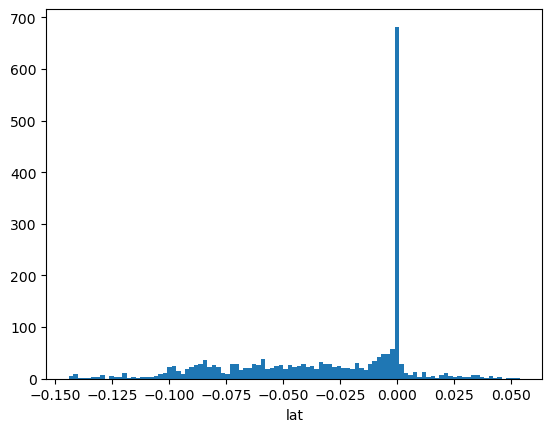

In [42]:
ds_trajectories.lat.diff("obs").plot.hist(bins=101);

## Maps

In [43]:
first_lat = ds_trajectories.isel(obs=0).lat
first_lon = ds_trajectories.isel(obs=0).lon

In [44]:
last_valid_obs = ds_trajectories.obs.where(ds_trajectories.lon.notnull()).max('obs').astype(int)
last_step = ds_trajectories.isel(obs=last_valid_obs).compute()

last_lon = last_step.lon
last_lat = last_step.lat

last_step.to_dataframe().describe()

,CellID,S,T,lat,lon,obs,time,u,v,z
count,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750,7.500000e+02,7.500000e+02,750.0
mean,49711.460938,5.109083,2.208294,60.082494,21.562770,3.000000,2021-01-04 05:44:59.712000,-2.327070e-06,-1.612378e-07,0.0
min,49699.000000,0.000000,-0.340000,58.403688,10.457944,1.000000,2021-01-04 05:44:59.712000,-7.208252e-06,-2.469227e-06,0.0
25%,49705.000000,3.346875,0.000000,59.480169,20.369476,1.000000,2021-01-04 05:44:59.712000,-3.633832e-06,-3.468080e-07,0.0
50%,49712.000000,5.890000,2.662501,59.940127,20.844770,3.000000,2021-01-04 05:44:59.712000,-2.515450e-06,0.000000e+00,0.0
75%,49718.000000,6.530000,3.628127,60.324562,23.656273,5.000000,2021-01-04 05:44:59.712000,-1.151552e-07,1.917118e-08,0.0
max,49723.000000,25.820002,5.847499,63.172999,26.948046,5.000000,2021-01-04 05:44:59.712000,1.668047e-07,1.032998e-06,0.0
std,7.163834,4.060543,1.831559,1.269526,3.240549,1.634083,NaN,1.690274e-06,5.460506e-07,0.0


In [45]:
traj_dead = ds_trajectories.where(first_lon == last_lon, drop=True)
traj_moving = ds_trajectories.where(first_lon != last_lon, drop=True)


In [46]:
# Read Files
data_path_orig_files = Path("/gxfs_work/geomar/smomw400/bsh_operationalmodel_data/")

z_files_fine = sorted(data_path_orig_files.glob(f"z_file_fine_{release_year}/*"))[first_file_count:last_file_count]
z_files_coarse = sorted(data_path_orig_files.glob(f"z_file_coarse_{release_year}/*"))[first_file_count:last_file_count]
# open eta and H0 files
ds_eta_fine = xr.open_dataset(z_files_fine[0])
ds_eta_coarse = xr.open_dataset(z_files_coarse[0])

NameError: name 'first_file_count' is not defined

In [ ]:
fig = plt.figure(figsize=(30,18))
ax = fig.add_subplot(
    1,1,1,
    projection= ccrs.PlateCarree(),
)

ds_eta_fine.elev.isel(time=0).plot.imshow(
    cmap=cmocean.cm.deep, ax=ax, 
)
ds_eta_coarse.elev.isel(time=0).plot.imshow(
    cmap=cmocean.cm.deep, ax=ax, 
)

# gdf_release_area.geometry.plot(ax=ax, color="gold", alpha=1)
# ax.scatter(traj_moving.lon, traj_moving.lat, c="b", s=1)
# ax.scatter(release_lons, release_lats, s=1, c="r")

ax.scatter(traj_dead.isel(obs=0).lon, traj_dead.isel(obs=0).lat, c="r", s=5)
ax.scatter(traj_moving.isel(obs=0).lon, traj_moving.isel(obs=0).lat, c="k", s=5)

# ax.scatter(ds_trajectories.lon, ds_trajectories.lat, c="b", cmap="rainbow", s=1, )
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.xlim(16.5,22)
plt.ylim(59.5,64)
# plt.xlim(21,25)
# plt.ylim(57.5,59)
# plt.xlim(9,25)
# plt.ylim(53.5,62.5)
plt.show()

In [ ]:
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(
    1,1,1,
    projection= ccrs.PlateCarree(),
)

ds_eta_fine.elev.isel(time=0).plot(
    cmap=cmocean.cm.deep, ax=ax, 
)
ds_eta_coarse.elev.isel(time=0).plot(
    cmap=cmocean.cm.deep, ax=ax, 
)

gdf_release_area.geometry.plot(ax=ax, color="gold", alpha=1)
ax.scatter(release_lons, release_lats, c="magenta", s=1)

ax.scatter(traj_dead.isel(obs=0).lon, traj_dead.isel(obs=0).lat, c="r", s=5)
ax.scatter(traj_moving.isel(obs=0).lon, traj_moving.isel(obs=0).lat, c="k", s=5)

ax.coastlines()
ax.gridlines(draw_labels=True)
plt.show()

In [ ]:
ganz_tot = np.unique(traj_dead.isel(obs=0).CellID.values)[
        np.invert(
                np.in1d(
                        np.unique(traj_dead.isel(obs=0).CellID.values),
                        np.unique(traj_moving.isel(obs=0).CellID.values)
                )
        )
]
len(ganz_tot)